# Количество используемых слоёв VGG

### Импорты

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision.transforms import Compose, Resize, ToTensor, ToPILImage
from torchvision.models import vgg19

from PIL import Image

import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_default_device(device)
device

device(type='cuda')

# Класс модели-стилизатора (см. baseline)

In [4]:
VGG19_NORMALIZATION_MEAN = torch.tensor([0.485, 0.456, 0.406])
VGG19_NORMALIZATION_STD = torch.tensor([0.229, 0.224, 0.225])

CONTENT_LAYERS_DEFAULT = ['Conv_4']
STYLE_LAYERS_DEFAULT = ['Conv_1', 'Conv_2', 'Conv_3', 'Conv_4', 'Conv_5']

In [5]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach().to(device)
        
    def forward(self, inp):
        self.loss = F.mse_loss(inp, self.target).to(device)
        return inp
    

class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = StyleLoss.gram_matrix(target).detach().to(device)
        
    @staticmethod
    def gram_matrix(inp):
        batch_size, nmaps, w, h = inp.size()
    
        features = inp.view(batch_size * nmaps, w * h) # Получаем для каждой карты признаков вектор размера wxh
    
        G = torch.mm(features, features.T)
    
        return G.div(batch_size * nmaps * w * h)

    
    def forward(self, inp):
        G = StyleLoss.gram_matrix(inp).to(device)
        self.loss = F.mse_loss(G, self.target).to(device)
        return inp

In [6]:
class Normalization(nn.Module):
    def __init__(self, mean=VGG19_NORMALIZATION_MEAN,
                 std=VGG19_NORMALIZATION_STD):
       super(Normalization, self).__init__()
       self.mean = torch.tensor(mean).view(-1, 1, 1)
       self.std = torch.tensor(std).view(-1, 1, 1)
   
    def forward(self, img):
       return (img - self.mean) / self.std

In [7]:
class StyleModel:
    """
    Класс для создания интерфейса по переносу стиля
    """
    def __init__(self, base_cnn, content_img, style_img, 
                 normalization_mean=VGG19_NORMALIZATION_MEAN, 
                 normalization_std=VGG19_NORMALIZATION_STD, 
                 content_layers=CONTENT_LAYERS_DEFAULT, 
                 style_layers=STYLE_LAYERS_DEFAULT):
        
        content_img = content_img.to(device)
        style_img = style_img.to(device)
        self.model = nn.Sequential().to(device)
        self.content_losses = []
        self.style_losses = []
        
        self.model.add_module("ImageNorm", Normalization(mean=normalization_mean, std=normalization_std).to(device))

        conv_counter: int = 0
        module_name: str = ""
        
        for layer in base_cnn.children():
            if isinstance(layer, nn.Conv2d):
                conv_counter += 1
                module_name = f"Conv_{conv_counter}"
                
            elif isinstance(layer, nn.ReLU):
                module_name = f"ReLU_{conv_counter}"
                layer = nn.ReLU(inplace=False)
                
            elif isinstance(layer, nn.MaxPool2d):
                module_name = f"MaxPool2d_{conv_counter}"
            
            else:
                raise ValueError
            
            self.model.add_module(module_name, layer.to(device))

            if module_name in content_layers:
                target = self.model(content_img).detach().to(device)
                content_loss_module = ContentLoss(target)
                self.content_losses.append(content_loss_module)
                self.model.add_module(f"ContentLoss_{conv_counter}", content_loss_module)
                
            if module_name in style_layers:
                target = self.model(style_img).detach().to(device)
                style_loss_module = StyleLoss(target)
                self.style_losses.append(style_loss_module)
                self.model.add_module(f"StyleLoss_{conv_counter}", style_loss_module)
                
        self.model.to(device)

    
    def __repr__(self):
        return f'{self.__class__.__name__}(model = {self.model})'


    def transfer_style(self, input_image, optimizer_class=None, lr=0.05, 
                       num_steps=300, style_weight=100000, content_weight=1, print_logs:int|None=None):
        
        input_image = input_image.to(device)
        
        input_image.requires_grad = True
        self.model.eval()

        optimizer = None
        if not optimizer_class:
            optimizer = optim.Adam([input_image], lr=lr)
        else:
            optimizer = optimizer_class([input_image], lr=lr)

        
        for i in range(num_steps):
            
            def closure():
                optimizer.zero_grad()

                self.model(input_image)
                content_final_loss = 0.0
                style_final_loss = 0.0
            
                for content_loss in self.content_losses:
                    content_final_loss += content_loss.loss

                for style_loss in self.style_losses:
                    style_final_loss += style_loss.loss

                loss = content_weight * content_final_loss + style_weight * style_final_loss
                loss.backward()

                return loss
                
            optimizer.step(closure)
            
            with torch.no_grad():
                input_image.clamp_(0, 1)

            if print_logs:
                if i % print_logs == 0:
                    print(f"Эпоха номер {i + 1}")
                    plt.imshow(ToPILImage()(input_image[0]))
                    plt.show()
                
        with torch.no_grad():
            input_image.clamp_(0, 1)
            
        return input_image

# Входные данные

In [8]:
import os

IMSIZE = (512, 512)

contents_directory = "/kaggle/input/images3-0/data/contents/"
styles_directory = "/kaggle/input/images3-0/data/styles/"

content_names = os.listdir(contents_directory) 
style_names = os.listdir(styles_directory)

content_images = [Image.open(contents_directory + filename).resize(IMSIZE) for filename in content_names]
style_images = [Image.open(styles_directory + filename).resize(IMSIZE) for filename in style_names]

# Эксперименты

## 1. Функция эксперимента

In [9]:
import time

In [10]:
def experiment(base_model, content_images, style_images, 
               optimizer, lr, num_steps, 
               content_weight, style_weight, 
               content_layers, style_layers, 
               noisy_input: bool = False, print_logs: int|None=None) -> dict[str, float]:
    
    results: dict[str, float] = {
        "avg_time": 0.0, 
        "content_score": 0.0,
        "style_score": 0.0
    }
    
    iteration_counter = 0
    total_time_spent_on_transfering = 0.0

    total_content_score = 0.0
    total_style_score = 0.0
    
    for content_img in content_images:
        for style_img in style_images:
            
            start = time.time()
            
            content = ToTensor()(content_img)[:3].unsqueeze(0)
            style = ToTensor()(style_img)[:3].unsqueeze(0)
        
            input_ = torch.randn(content.data.size()) if noisy_input else content.clone()
            
            style_model = StyleModel(
                base_cnn=base_model,
                content_img=content,
                style_img=style,
                content_layers=content_layers,
                style_layers=style_layers
            )

            output = style_model.transfer_style(
                input_image=input_,
                optimizer_class=optimizer,
                lr=lr,
                num_steps=num_steps,
                content_weight=content_weight,
                style_weight=style_weight,
                print_logs=print_logs
            )
            
            end = time.time()
            total_time_spent_on_transfering += end - start
            iteration_counter += 1

            with torch.no_grad():
                total_content_score += F.mse_loss(output.to(device), content.to(device)).item()
                style_loss = StyleLoss(style)
                style_loss(output)
                total_style_score += style_loss.loss.item()

            fig, axes = plt.subplots(1, 3, figsize=(13, 16))
            axes[0].set_title("Content")
            axes[1].set_title("Style")
            axes[2].set_title("Result")
            axes[0].imshow(content_img)
            axes[1].imshow(style_img)
            axes[2].imshow(ToPILImage()(output[0]))
            plt.show()
            
    results["avg_time"] = total_time_spent_on_transfering / iteration_counter
    results["content_score"] = total_content_score / iteration_counter
    results["style_score"] = total_style_score / iteration_counter
    
    return results

## 2. Выбор количества слоёв VGG

### 2.1. Бейзлайновое решение - 11 слоев, 5 свёрток

In [11]:
base_cnn = vgg19(pretrained=True).features[0 : 11].to(device)

for param in base_cnn.parameters():
    param.requires_grad = False

base_cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [12]:
OPTIMIZER = optim.Adam
LR = 0.05
NUM_STEPS=400
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 10**8
CONTENT_LAYERS = CONTENT_LAYERS_DEFAULT
STYLE_LAYERS = STYLE_LAYERS_DEFAULT

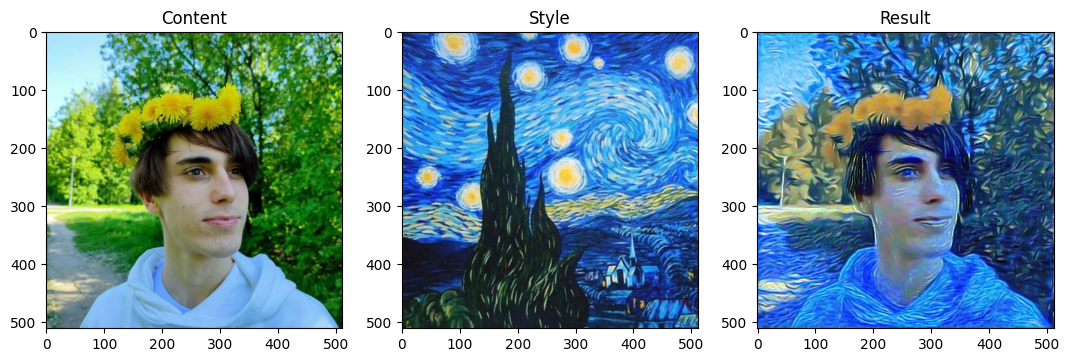

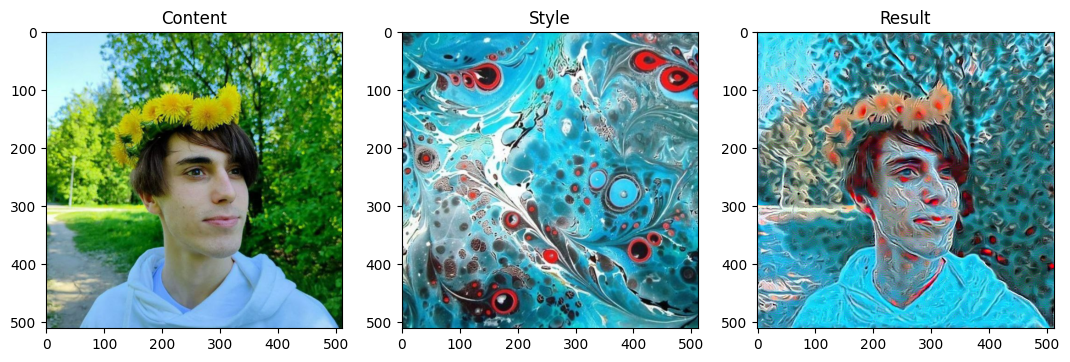

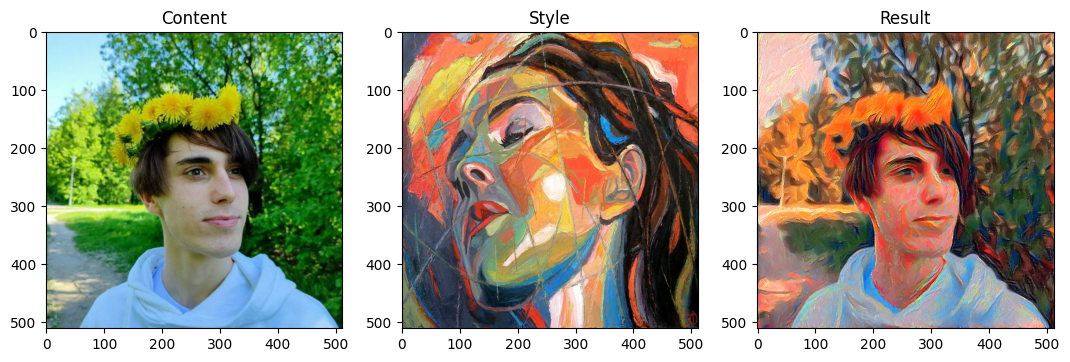

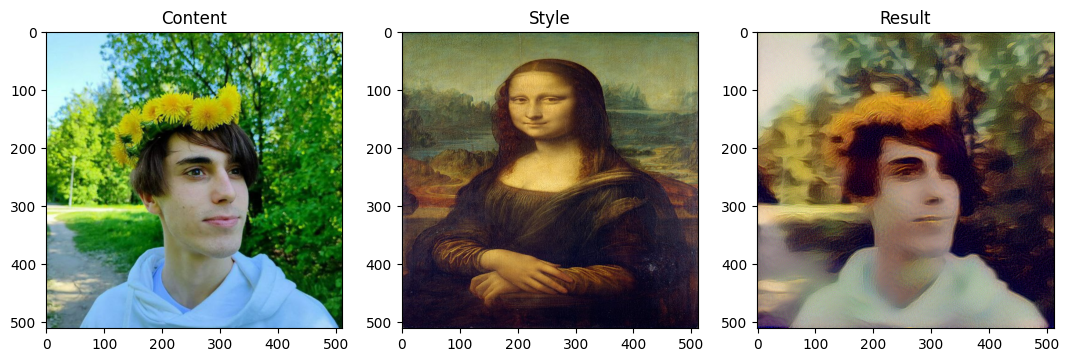

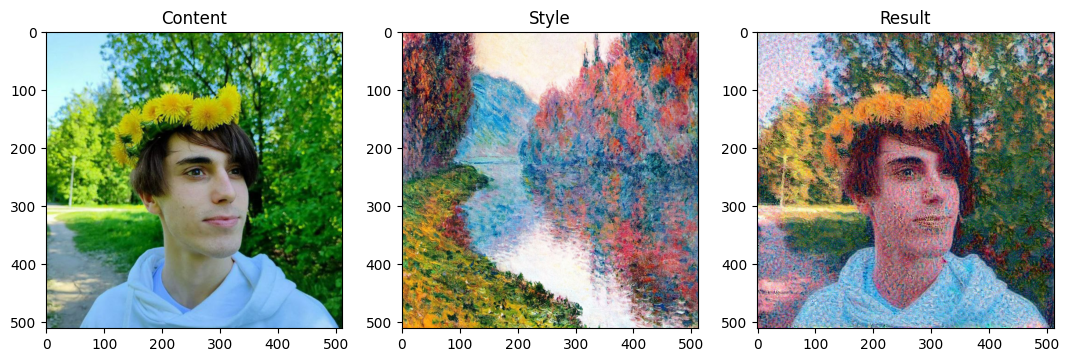

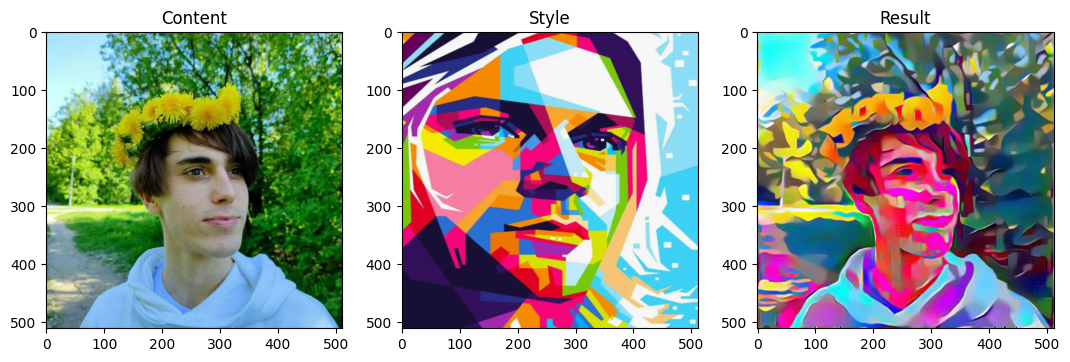

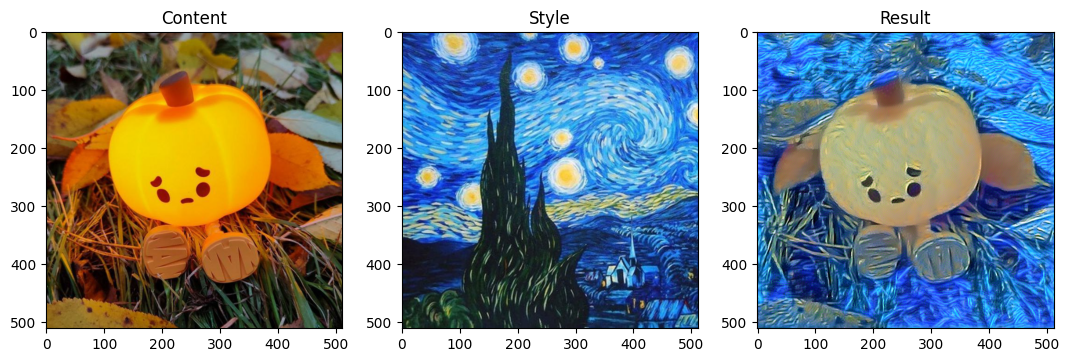

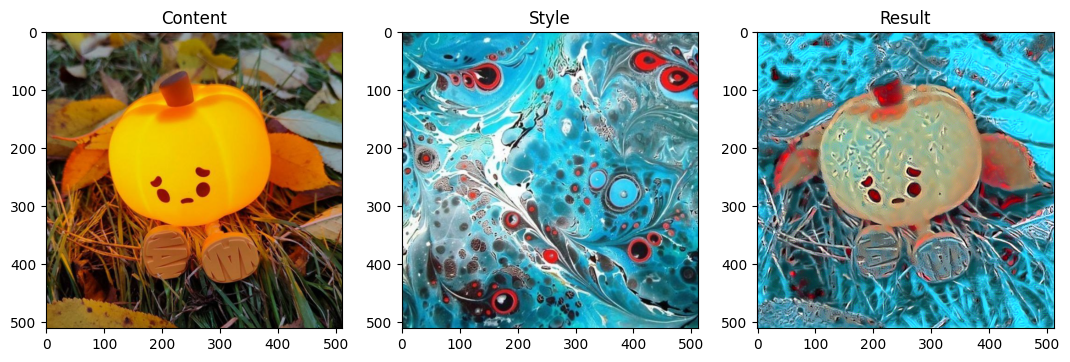

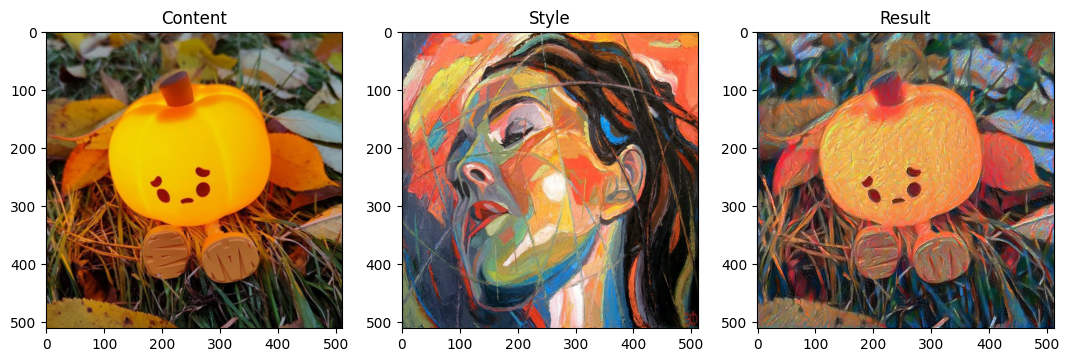

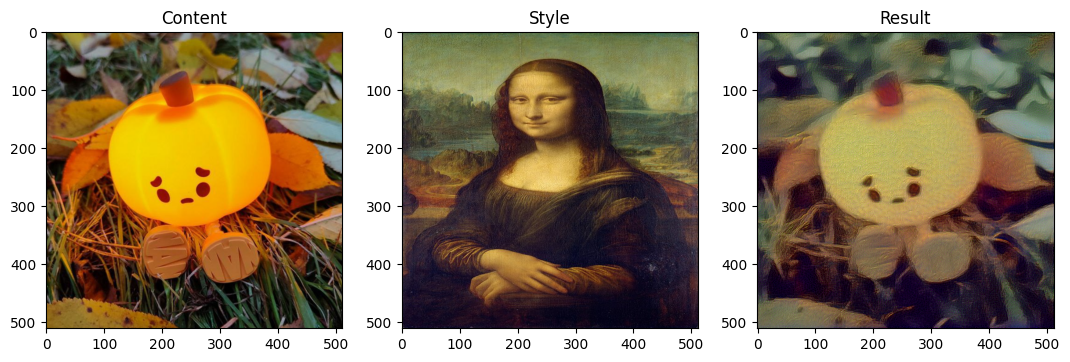

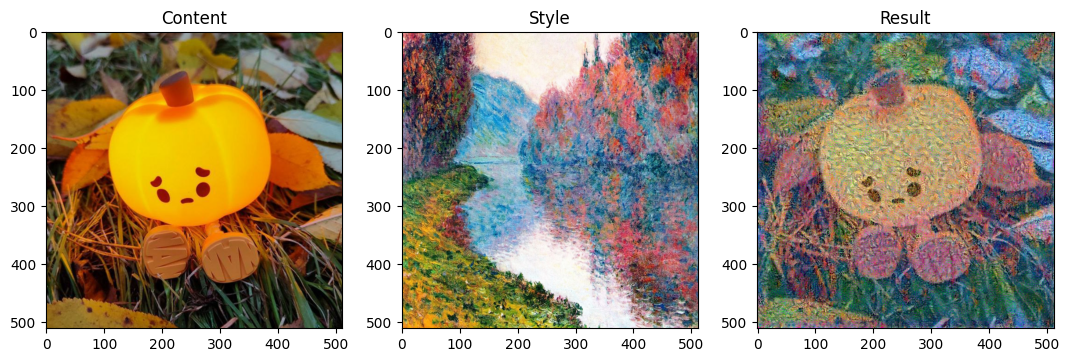

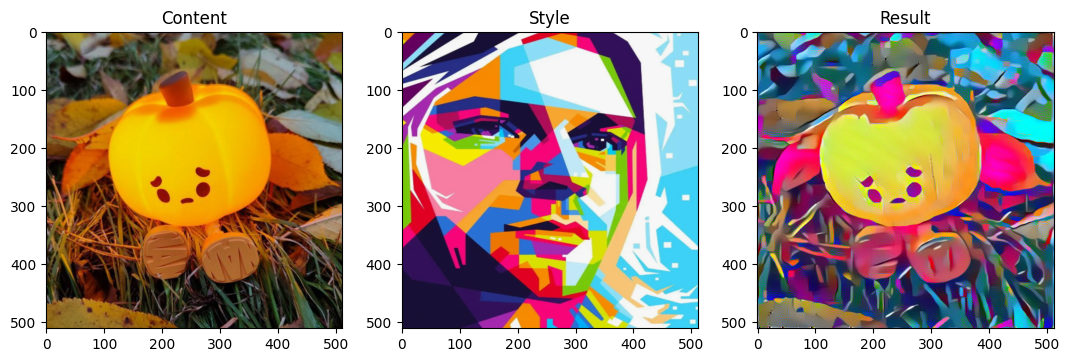

In [13]:
results = experiment(
    base_model=base_cnn,
    content_images=content_images[8:10], 
    style_images=style_images[4:10],
    optimizer=OPTIMIZER, 
    lr=LR, 
    num_steps=NUM_STEPS, 
    content_weight=CONTENT_WEIGHT, 
    style_weight=STYLE_WEIGHT, 
    content_layers=CONTENT_LAYERS, 
    style_layers=STYLE_LAYERS,
    noisy_input=False,
    print_logs=None)

In [24]:
result

{'avg_time': 10.7481,
 'content_score': 0.0314144480210543,
 'style_score': 0.0015353436165562}

### 2.2. 17 слоёв (8 сверток)

In [15]:
base_cnn = vgg19(pretrained=True).features[0 : 17].to(device)

for param in base_cnn.parameters():
    param.requires_grad = False

base_cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [16]:
OPTIMIZER = optim.Adam
LR = 0.05
NUM_STEPS=400
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 10**8
CONTENT_LAYERS = ['Conv_7', 'Conv_8']
STYLE_LAYERS = [f'Conv_{i}' for i in range(1, 9)]

In [ ]:
results = experiment(
    base_model=base_cnn,
    content_images=content_images[8:10], 
    style_images=style_images[4:10],
    optimizer=OPTIMIZER, 
    lr=LR, 
    num_steps=NUM_STEPS, 
    content_weight=CONTENT_WEIGHT, 
    style_weight=STYLE_WEIGHT, 
    content_layers=CONTENT_LAYERS, 
    style_layers=STYLE_LAYERS,
    noisy_input=False,
    print_logs=None
)

In [25]:
results

{'avg_time': 15.597521662712097,
 'content_score': 0.041549883272250496,
 'style_score': 0.0005501802809611738}

### 2.3. Все свёрточные слои VGG (16 свёрток)

In [19]:
base_cnn = vgg19(pretrained=True).features[0 : 35].to(device)

for param in base_cnn.parameters():
    param.requires_grad = False

base_cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [20]:
OPTIMIZER = optim.Adam
LR = 0.05
NUM_STEPS=400
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 10**8
CONTENT_LAYERS = ['Conv_15', 'Conv_16']
STYLE_LAYERS = [f'Conv_{i}' for i in range(1, 17)]

In [ ]:
results = experiment(
    base_model=base_cnn,
    content_images=content_images[8:10], 
    style_images=style_images[4:10],
    optimizer=OPTIMIZER, 
    lr=LR, 
    num_steps=NUM_STEPS, 
    content_weight=CONTENT_WEIGHT, 
    style_weight=STYLE_WEIGHT, 
    content_layers=CONTENT_LAYERS, 
    style_layers=STYLE_LAYERS,
    noisy_input=False,
    print_logs=None
)

In [26]:
results

{'avg_time': 23.758590936660767,
 'content_score': 0.0397284357839823,
 'style_score': 0.000604297043492969}